!pip install geocoder
!pip install folium
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

## 2. Data Extraction and Cleaning

In [59]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T"
dfs = pd.read_html(url)

# Dropping the given Latitude/Longitude, to add them via postal code
df = dfs[1]
df = df.drop(['Latitude', 'Longitude'], axis=1)
df

,Postal Code,Borough,Neighborhood
0,T1A,Medicine Hat,Central Medicine Hat
1,T2A,Calgary,"Penbrooke Meadows, Marlborough"
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley"
3,T4A,Airdrie,East Airdrie
4,T5A,Edmonton,"West Clareview, East Londonderry"
5,T6A,Edmonton,North Capilano
6,T7A,Drayton Valley,Not assigned
7,T8A,Sherwood Park,West Sherwood Park
8,T9A,Wetaskiwin,Not assigned
9,T1B,Medicine Hat,South Medicine Hat


### Dropping all empty columns and postal codes not associated with Calgary, AB

In [5]:
df.dropna(inplace=True)
empty = 'Not assigned'

df = df[((df['Postal Code'] != empty ) & (df['Borough'] == 'Calgary') & (df['Neighborhood'] != empty))]

print(df.shape)
df.head()

(35, 3)


,Postal Code,Borough,Neighborhood
1,T2A,Calgary,"Penbrooke Meadows, Marlborough"
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley"
10,T2B,Calgary,"Forest Lawn, Dover, Erin Woods"
11,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood"
19,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G..."


In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postal Code', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

print(df_2.shape)
df_2

(35, 3)


,Postal Code,Borough,Neighborhood
0,T1Y,Calgary,"Rundle, Whitehorn, Monterey Park"
1,T2A,Calgary,"Penbrooke Meadows, Marlborough"
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods"
3,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G..."
4,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC"
5,T2G,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria..."
6,T2H,Calgary,"Highfield, Burns Industrial"
7,T2J,Calgary,"Queensland, Lake Bonavista, Willow Park, Acadia"
8,T2K,Calgary,"Thorncliffe, Tuxedo Park"
9,T2L,Calgary,"Brentwood, Collingwood, Nose Hill"


### Obtaining the Coordinates via Postal Code

In [10]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Calgary, AB'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('T3H')

[51.04606000000007, -114.19917999999996]

In [12]:
postal_codes = df_2['Postal Code']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [13]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [14]:
df_2[df_2['Postal Code'] == 'T3H']

,Postal Code,Borough,Neighborhood,Latitude,Longitude
26,T3H,Calgary,"Discovery Ridge, Signal Hill, West Springs, Ch...",51.04606,-114.19918


In [15]:
df_2.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1Y,Calgary,"Rundle, Whitehorn, Monterey Park",51.08309,-113.95673
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.05169,-113.95673
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.02208,-113.96030
3,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.97847,-113.97687
4,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC",51.09146,-114.02753
5,T2G,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria...",51.02934,-114.03047
6,T2H,Calgary,"Highfield, Burns Industrial",50.98864,-114.04735
7,T2J,Calgary,"Queensland, Lake Bonavista, Willow Park, Acadia",50.94364,-114.04179
8,T2K,Calgary,"Thorncliffe, Tuxedo Park",51.10047,-114.07256
9,T2L,Calgary,"Brentwood, Collingwood, Nose Hill",51.10720,-114.12118


In [16]:
address = 'Calgary,Alberta'

geolocator = Nominatim(user_agent="my_app")
location = geolocator.geocode(address)
lat_x = location.latitude
long_y = location.longitude
print('The Geograpical Co-ordinate of Calgary,Alberta are {}, {}.'.format(lat_x, long_y))

The Geograpical Co-ordinate of Calgary,Alberta are 51.0534234, -114.0625892.


## 3. Map of Calgary

In [44]:
map_Calgary = folium.Map(location=[lat_x, long_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Calgary)  
    
map_Calgary

In [17]:
CLIENT_ID = 'UIP021GJ3T4BJVUYUZ4L0VT4E3NIS51TIBN4YX5I0UY2R2GE' # your Foursquare ID
CLIENT_SECRET = 'DJKRCL4CTCPWJRSCPRDYW524IVAX35SZ2AC2FVKJLF5S0TBK' # your Foursquare Secret
VERSION = '20210218' # Foursquare API version
LIMIT = 5000 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UIP021GJ3T4BJVUYUZ4L0VT4E3NIS51TIBN4YX5I0UY2R2GE
CLIENT_SECRET:DJKRCL4CTCPWJRSCPRDYW524IVAX35SZ2AC2FVKJLF5S0TBK


In [63]:
radius = 5000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat_x, 
   long_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [64]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 4. Nearby Venues/Locations

In [65]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Prince's Island Park,Park,51.054884,-114.069929
1,River Walk,Scenic Lookout,51.051413,-114.059962
2,1886 Cafe,Café,51.052392,-114.069475
3,Phil & Sebastian Coffee Roasters,Coffee Shop,51.047816,-114.050092
4,Over Easy Breakfast,Breakfast Spot,51.048561,-114.065917
5,Jack Singer Concert Hall,Performing Arts Venue,51.045437,-114.060184
6,Top Of Stairs In Crescent Heights,Scenic Lookout,51.059010,-114.067619
7,Lukes Drug Mart,Pharmacy,51.053187,-114.051327
8,Sheraton Suites Calgary Eau Claire,Hotel,51.051886,-114.069935
9,Theatre Calgary,Theater,51.044677,-114.058510


## 5. Categories of Nearby Venues/Locations

In [66]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Restaurant              9
Coffee Shop             6
Steakhouse              4
Pub                     4
Diner                   4
Italian Restaurant      3
Deli / Bodega           3
Bakery                  3
Pizza Place             3
Gym / Fitness Center    2
Name: categories, dtype: int64

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=50000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
#Nearby Venues
calgary_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Rundle, Whitehorn, Monterey Park
Penbrooke Meadows, Marlborough
Forest Lawn, Dover, Erin Woods
Lynnwood Ridge, Ogden, Foothills Industrial, Great Plains
Bridgeland, Greenview, Zoo, YYC
Inglewood, Burnsland, Chinatown, East Victoria Park, Saddledome
Highfield, Burns Industrial
Queensland, Lake Bonavista, Willow Park, Acadia
Thorncliffe, Tuxedo Park
Brentwood, Collingwood, Nose Hill
Mount Pleasant, Capitol Hill, Banff Trail
Kensington, Westmont, Parkdale, University
City Centre, Calgary Tower
Connaught, West Victoria Park
Elbow Park, Britannia, Parkhill, Mission
South Calgary (Altadore / Bankview / Richmond)
Oak Ridge, Haysboro, Kingsland, Kelvin Grove, Windsor Park
Braeside, Cedarbrae, Woodbine
Midnapore, Sundance
Millrise, Somerset, Bridlewood, Evergreen
Douglas Glen, McKenzie Lake, Copperfield, East Shepard
Dalhousie, Edgemont, Hamptons, Hidden Valley
Montgomery, Bowness, Silver Springs, Greenwood
Rosscarrock, Westgate, Wildwood, Shaganappi, Sunalta
Lakeview, Glendale, Killarney, Glam

In [33]:
print('There are {} Uniques Categories.'.format(len(calgary_venues['Venue Category'].unique())))
calgary_venues.groupby('Neighborhood').count().head()

There are 68 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",100,100,100,100,100,100
"Brentwood, Collingwood, Nose Hill",100,100,100,100,100,100
"Bridgeland, Greenview, Zoo, YYC",100,100,100,100,100,100
"City Centre, Calgary Tower",100,100,100,100,100,100
"Connaught, West Victoria Park",100,100,100,100,100,100


### One Hot Encoding of Features

In [34]:
calgary_onehot = pd.get_dummies(calgary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
calgary_onehot['Neighborhood'] = calgary_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]
calgary_onehot.head(5)

,Neighborhood,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Field,Beer Store,Bookstore,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dog Run,Electronics Store,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Frozen Yogurt Shop,Garden Center,Gas Station,Gastropub,Golf Course,Greek Restaurant,Grocery Store,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Movie Theater,Music Store,Park,Pharmacy,Pizza Place,Pub,Restaurant,Sandwich Place,Scenic Lookout,Shopping Mall,Skating Rink,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Supermarket,Sushi Restaurant,Theater,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Shop,Zoo
0,"Rundle, Whitehorn, Monterey Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Rundle, Whitehorn, Monterey Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Rundle, Whitehorn, Monterey Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Rundle, Whitehorn, Monterey Park",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Rundle, Whitehorn, Monterey Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
calgary_Grouped = calgary_onehot.groupby('Neighborhood').mean().reset_index()
calgary_Grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Field,Beer Store,Bookstore,Breakfast Spot,Brewery,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dog Run,Electronics Store,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Frozen Yogurt Shop,Garden Center,Gas Station,Gastropub,Golf Course,Greek Restaurant,Grocery Store,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Movie Theater,Music Store,Park,Pharmacy,Pizza Place,Pub,Restaurant,Sandwich Place,Scenic Lookout,Shopping Mall,Skating Rink,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Supermarket,Sushi Restaurant,Theater,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Shop,Zoo
0,"Braeside, Cedarbrae, Woodbine",0.00,0.010000,0.030000,0.040000,0.020000,0.01,0.010000,0.020000,0.010000,0.020000,0.020000,0.030000,0.00,0.060000,0.010000,0.010000,0.010000,0.000000,0.010000,0.010000,0.020000,0.01,0.020000,0.000000,0.020000,0.01,0.010000,0.000000,0.010000,0.01,0.00,0.030000,0.010000,0.020000,0.020000,0.010000,0.00,0.00,0.030000,0.00,0.010000,0.010000,0.010000,0.010000,0.070000,0.010000,0.020000,0.020000,0.090000,0.020000,0.00,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.020000,0.010000,0.010000,0.010000,0.010000,0.00,0.01,0.010000,0.010000,0.010000
1,"Brentwood, Collingwood, Nose Hill",0.00,0.010000,0.030000,0.040000,0.020000,0.01,0.010000,0.020000,0.010000,0.020000,0.020000,0.030000,0.00,0.080000,0.010000,0.010000,0.010000,0.000000,0.010000,0.010000,0.020000,0.01,0.020000,0.000000,0.020000,0.01,0.010000,0.000000,0.010000,0.01,0.00,0.030000,0.010000,0.020000,0.010000,0.010000,0.00,0.00,0.030000,0.00,0.010000,0.010000,0.010000,0.010000,0.070000,0.010000,0.020000,0.020000,0.080000,0.020000,0.00,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.020000,0.010000,0.010000,0.010000,0.010000,0.00,0.01,0.010000,0.010000,0.010000
2,"Bridgeland, Greenview, Zoo, YYC",0.00,0.010000,0.030000,0.040000,0.020000,0.01,0.010000,0.020000,0.010000,0.020000,0.020000,0.030000,0.01,0.060000,0.010000,0.010000,0.010000,0.000000,0.010000,0.010000,0.020000,0.01,0.020000,0.000000,0.020000,0.01,0.010000,0.000000,0.010000,0.01,0.00,0.040000,0.010000,0.020000,0.010000,0.010000,0.00,0.00,0.030000,0.00,0.010000,0.010000,0.010000,0.010000,0.070000,0.010000,0.020000,0.020000,0.080000,0.020000,0.00,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.020000,0.010000,0.010000,0.010000,0.010000,0.00,0.01,0.010000,0.010000,0.010000
3,"City Centre, Calgary Tower",0.02,0.010000,0.030000,0.040000,0.020000,0.01,0.010000,0.020000,0.010000,0.020000,0.010000,0.050000,0.00,0.040000,0.010000,0.010000,0.020000,0.000000,0.010000,0.010000,0.020000,0.01,0.010000,0.000000,0.010000,0.00,0.000000,0.000000,0.010000,0.02,0.01,0.040000,0.010000,0.020000,0.020000,0.010000,0.01,0.00,0.030000,0.00,0.010000,0.010000,0.010000,0.010000,0.070000,0.010000,0.030000,0.020000,0.060000,0.010000,0.00,0.010000,0.010000,0.010000,0.020000,0.010000,0.020000,0.010000,0.030000,0.010000,0.000000,0.010000,0.010000,0.01,0.00,0.000000,0.010000,0.010000
4,"Connaught, West Victoria Park",0.02,0.010000,0.030000,0.040000,0.020000,0.01,0.010000,0.020000,0.010000,0.020000,0.010000,0.050000,0.00,0.040000,0.010000,0.010000,0.020000,0.000000,0.010000,0.010000,0.020000,0.01,0.010000,0.000000,0.010000,0.00,0.000000,0.000000,0.010000,0.02,0.01,0.040000,0.010000,0.020000,0.020000,0.020000,0.01,0.00,0.030000,0.00,0.010000,0.010000,0.010000,0.010000,0.070000,0.010000,0.020000,0.020000,0.060000,0.010000,0.00,0.010000,0.010000,0.010000,0.020000,0.010000,0.020000,0.010000,0.030000,0.010000,0.000000,0.010000,0.010000,0.01,0.00,0.000000,0.010000,0.010000
5,"Cranston, Auburn Bay, Mahogany",0.01,0.010000,0.030000,0.040000,0.020000,0.01,0.010000,0.020000,0.0100

In [36]:
num_top_venues = 5

for hood in calgary_Grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = calgary_Grouped[Alberta_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Braeside, Cedarbrae, Woodbine----
         venue  freq
0   Restaurant  0.09
1         Park  0.07
2  Coffee Shop  0.06
3       Bakery  0.04
4    BBQ Joint  0.03


----Brentwood, Collingwood, Nose Hill----
         venue  freq
0   Restaurant  0.08
1  Coffee Shop  0.08
2         Park  0.07
3       Bakery  0.04
4    BBQ Joint  0.03


----Bridgeland, Greenview, Zoo, YYC----
           venue  freq
0     Restaurant  0.08
1           Park  0.07
2    Coffee Shop  0.06
3         Bakery  0.04
4  Grocery Store  0.04


----City Centre, Calgary Tower----
           venue  freq
0           Park  0.07
1     Restaurant  0.06
2           Café  0.05
3         Bakery  0.04
4  Grocery Store  0.04


----Connaught, West Victoria Park----
           venue  freq
0           Park  0.07
1     Restaurant  0.06
2           Café  0.05
3         Bakery  0.04
4  Grocery Store  0.04


----Cranston, Auburn Bay, Mahogany----
                venue  freq
0          Restaurant  0.08
1                Park  0.07
2       

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most common venues near neighborhood

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = calgary_Grouped['Neighborhood']

for ind in np.arange(calgary_Grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_Grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Restaurant,Park,Coffee Shop,Bakery,BBQ Joint,Grocery Store,Italian Restaurant,Café,Hotel,Farmers Market
1,"Brentwood, Collingwood, Nose Hill",Coffee Shop,Restaurant,Park,Bakery,Grocery Store,Italian Restaurant,BBQ Joint,Café,Food & Drink Shop,Farmers Market
2,"Bridgeland, Greenview, Zoo, YYC",Restaurant,Park,Coffee Shop,Bakery,Grocery Store,Café,BBQ Joint,Italian Restaurant,Hotel,Pizza Place
3,"City Centre, Calgary Tower",Park,Restaurant,Café,Bakery,Coffee Shop,Grocery Store,Sushi Restaurant,BBQ Joint,Pizza Place,Italian Restaurant
4,"Connaught, West Victoria Park",Park,Restaurant,Café,Grocery Store,Bakery,Coffee Shop,BBQ Joint,Italian Restaurant,Sushi Restaurant,Pizza Place


### K-Means Clustering Approach

In [38]:
calgary_grouped_clustering = calgary_Grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(calgary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1,
       2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0], dtype=int32)

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

calgary_merged =df_2.iloc[:16,:]

# merge calgary_grouped with calgary data to add latitude/longitude for each neighborhood
calgary_merged = calgary_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [40]:
calgary_merged# check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T1Y,Calgary,"Rundle, Whitehorn, Monterey Park",51.08309,-113.95673,2,Restaurant,Coffee Shop,Park,Grocery Store,Bakery,Café,Italian Restaurant,BBQ Joint,Bar,Bookstore
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.05169,-113.95673,2,Restaurant,Park,Coffee Shop,Bakery,Grocery Store,Café,BBQ Joint,Italian Restaurant,Hotel,Pizza Place
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.02208,-113.96030,1,Park,Restaurant,Bakery,Café,Coffee Shop,Grocery Store,Sushi Restaurant,BBQ Joint,Pizza Place,Italian Restaurant
3,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.97847,-113.97687,1,Park,Restaurant,Coffee Shop,Bakery,Café,BBQ Joint,Italian Restaurant,Sushi Restaurant,Grocery Store,Hotel
4,T2E,Calgary,"Bridgeland, Greenview, Zoo, YYC",51.09146,-114.02753,2,Restaurant,Park,Coffee Shop,Bakery,Grocery Store,Café,BBQ Joint,Italian Restaurant,Hotel,Pizza Place
5,T2G,Calgary,"Inglewood, Burnsland, Chinatown, East Victoria...",51.02934,-114.03047,1,Park,Restaurant,Café,Bakery,Coffee Shop,Grocery Store,Sushi Restaurant,BBQ Joint,Pizza Place,Italian Restaurant
6,T2H,Calgary,"Highfield, Burns Industrial",50.98864,-114.04735,2,Coffee Shop,Park,Restaurant,Bakery,BBQ Joint,Italian Restaurant,Café,Grocery Store,Hotel,Ice Cream Shop
7,T2J,Calgary,"Queensland, Lake Bonavista, Willow Park, Acadia",50.94364,-114.04179,2,Restaurant,Park,Coffee Shop,Bakery,BBQ Joint,Italian Restaurant,Café,Grocery Store,Hotel,Ice Cream Shop
8,T2K,Calgary,"Thorncliffe, Tuxedo Park",51.10047,-114.07256,1,Park,Restaurant,Coffee Shop,Sushi Restaurant,Bakery,Café,Grocery Store,BBQ Joint,Pizza Place,Italian Restaurant
9,T2L,Calgary,"Brentwood, Collingwood, Nose Hill",51.10720,-114.12118,2,Coffee Shop,Restaurant,Park,Bakery,Grocery Store,Italian Restaurant,BBQ Joint,Café,Food & Drink Shop,Farmers Market


### Map of Clusters

In [41]:
kclusters = 3
map_clusters = folium.Map(location=[lat_x, long_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, 2, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(calgary_merged['Latitude'], 
                                   calgary_merged['Longitude'], 
                                   calgary_merged['Neighborhood'], 
                                   calgary_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#ff0000']


In [48]:
df1=calgary_merged.loc[calgary_merged['Cluster Labels'] == 0,calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]
df2=calgary_merged.loc[calgary_merged['Cluster Labels'] == 1,calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]
df3=calgary_merged.loc[calgary_merged['Cluster Labels'] == 2,calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]

In [42]:
calgary_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[304206.0,496400.0,570327.0,394406.0,733269.0,570021.0,
                                                               210000.0,422740.0,629057.0,546705.0,790345.0,785858.0,
                                                               587318.0,396345.0,1844958.0,466396.0,483137.0,235830.0,
                                                               386229.0,407781.0,590022.0,395514.0,570215.0,1083484.0,
                                                               386188.0,467415.0,784950.0,446200.0,400677.0,493324.0,
                                                               682375.0,443300.0,472878.0,500000.0,483300]})

In [44]:
calgary_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

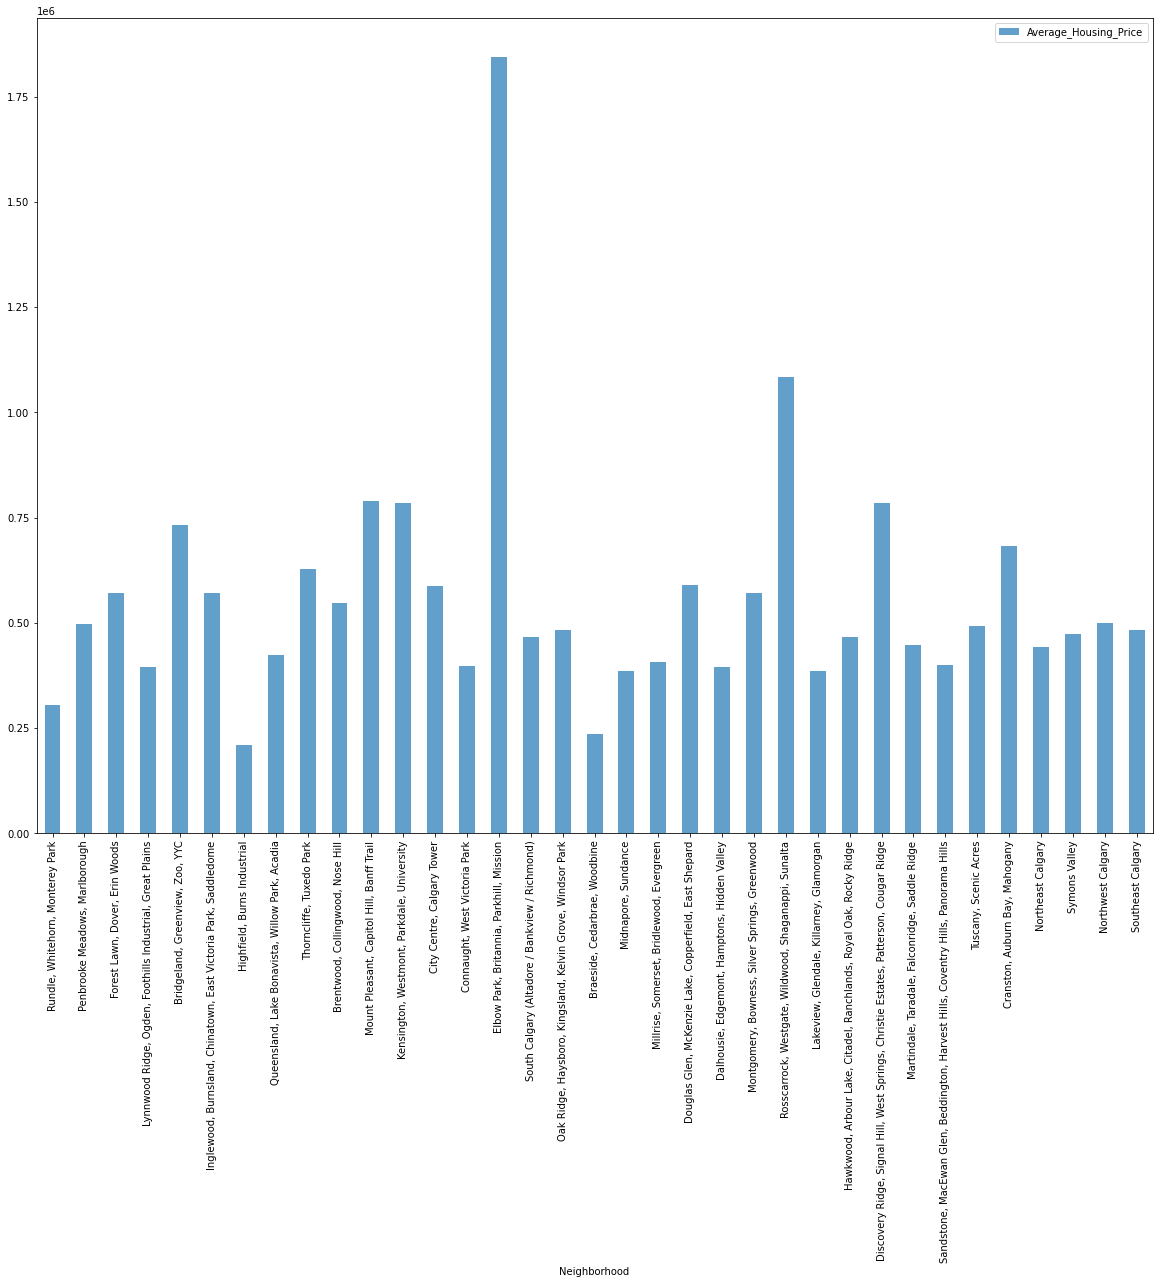

In [46]:
calgary_Avg_HousingPrice.plot(kind='bar',figsize=(20,15),alpha=0.7)

In [49]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [56]:
new_Calgary=calgary_merged.set_index("Neighborhood",drop=True)
#Source:https://www.compareschoolrankings.org/
calgary_school_ratings=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Top School Rating":[4.4,4.4,5.5,5.4,7.5,4.6,0,
                                                           6.2,4.2,7.2,8.1,7.4,0,0,7.8,
                                                           8.6,8.7,8.0,5.3,7.9,6.0,7.3,
                                                           6.3,6.2,8.2,6.7,5.3,7.3,7.5,
                                                           5.8,6.5,7.1,5.5,7.1,5.5]})

In [57]:
calgary_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

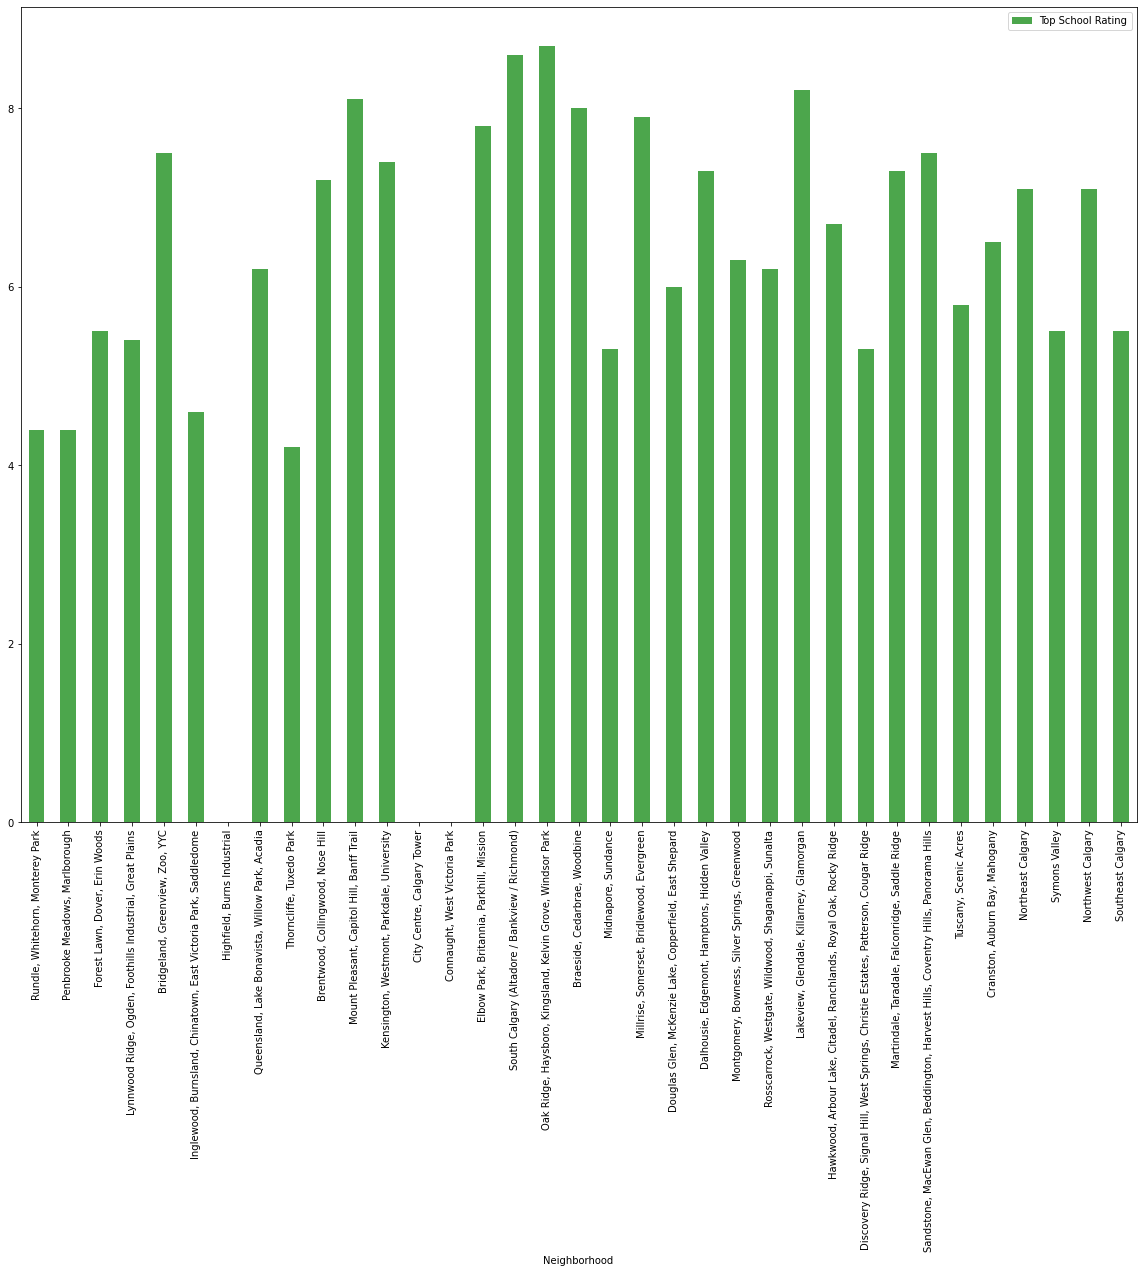

In [58]:
calgary_school_ratings.plot(kind='bar',figsize=(20,15),color='green',alpha=0.7);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 35 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.